#### Notes

This file contains the code used for the simulations in Figures 2 and in Appendix E.1, E.3, E.4, and E.5 .

(This file contains the code for our algorithm and for GDA, for the MNIST dataset.  For our algorithm with acceptance rate 1/5, set the "rate" paramter to "rate = 5".  For GDA, set the "rate" parameter to rate = 1.)



In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import random


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.optimizers import Adam#, SGD
import sys
sys.path.append("../")

from utils_Picky_grayscale import *       # utils file has the filler code and helper functions

from tqdm.notebook import tqdm
from functools import partial

Using TensorFlow backend.
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
NOISE_SIZE = 100
IMAGE_SIZE = 784

In [3]:
#set filter = true to include only the digits "0" and "1" in the MNIST dataset
X, _, _, _ = load_data(filter=True)

In [4]:
adam_optimizer = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

In [5]:
take_discriminator_steps_2 = partial(take_discriminator_steps, X_train=X, k=1)
getLoss2 = partial(getLoss, X_train=X)
create_gan2 = partial(create_gan, opt=adam_optimizer)

def create_GAN_player():
    ganPlayer = Players(create_generator(OUTPUT_SIZE=IMAGE_SIZE, opt=adam_optimizer), create_discriminator(INPUT_SIZE=IMAGE_SIZE, opt=adam_optimizer), create_gan2, take_generator_steps, take_discriminator_steps_2, change_network, change_network, perturb_generator)    
    return ganPlayer


In [6]:
def training_gd(create_player_function, create_player_function2):
    #Number of iterations
    T=2000      

    # this will create a Players object, with two players
    player = create_player_function()
    player2 = create_player_function2()

    j = 0
    
    Loss=[]
    
    old_loss = 100
    player.update_y()

    
    #how often to not accept/reject
    rate = 5
    
    
    for j in tqdm(range(T)):
        
        if j%1 == 0:
            print("\nIteration ", j)            
            loss = player.value(getLoss2)            
            print("Starting Loss: ", loss)
            if j>0:
                Loss.append(loss)
        
        
        #save generator weights and the old loss    


            player2.change_x(player.get_x())        
            player2.change_y(player.get_y())
            loss_old = player.value(getLoss2)  
            print("Old Loss: ", loss_old)
        
        
        # perform one gradient update for the generator and one gradient update for the discriminator (we only use "k=1" discriminator gradient steps for MNIST)
        player.update_x()        
        player.update_y()        
        
        
        #

        #Accept/reject Step
        if j%rate != 0:
            loss_new = player.value(getLoss2)            
        
            if loss_new > loss_old:
                print("Reject")
                player.change_x(player2.get_x())        
                player.change_y(player2.get_y())
            else:
                print("Accept")



        

#
        
        if (j%100 == 0 and j<3001) or j%1000==0:
            loss = player.value(getLoss2)
            print("Ending Loss:",  loss)
            folder_name ='results'
            filename = '/our_algorithm_MNIST'
            #plot the genererated images ()
            plot_generated_images(j, player.get_x(),folder=folder_name, save=False, name=filename+' %d.png')
            
            if j>0:
                plt.plot(Loss)
                #save the loss values (commented out here)
            #    np.save(folder_name + filename + '_loss_values', Loss)
        
    return player

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




Iteration  0
Starting Loss:  -0.79030615
Old Loss:  -0.78711814
Ending Loss: -0.7794432

Iteration  1
Starting Loss:  -0.7747443
Old Loss:  -0.7777655
Accept

Iteration  2
Starting Loss:  -0.8012433
Old Loss:  -0.8005272
Accept

Iteration  3
Starting Loss:  -0.805411
Old Loss:  -0.80995286
Reject

Iteration  4
Starting Loss:  -0.81115997
Old Loss:  -0.8025074
Reject

Iteration  5
Starting Loss:  -0.81032354
Old Loss:  -0.8127424

Iteration  6
Starting Loss:  -0.7655373
Old Loss:  -0.7579387
Reject

Iteration  7
Starting Loss:  -0.7575592
Old Loss:  -0.75162715
Reject

Iteration  8
Starting Loss:  -0.7532822
Old Loss:  -0.76063025
Reject

Iteration  9
Starting Loss:  -0.75944245
Old Loss:  -0.7597284
Reject

Iteration  10
Starting Loss:  -0.7565239
Old Loss:  -0.75909984

Iteration  11
Starting Loss:  -0.7075538
Old Loss:  -0.70805293
Reject

Iteration  12
Starting Loss:  -0.707302
Old Loss:  -0.70968
Reject

Iteration  13
Starting Loss:  -0.7079062
Old Loss:  -0.7111596
Reject

Iterat

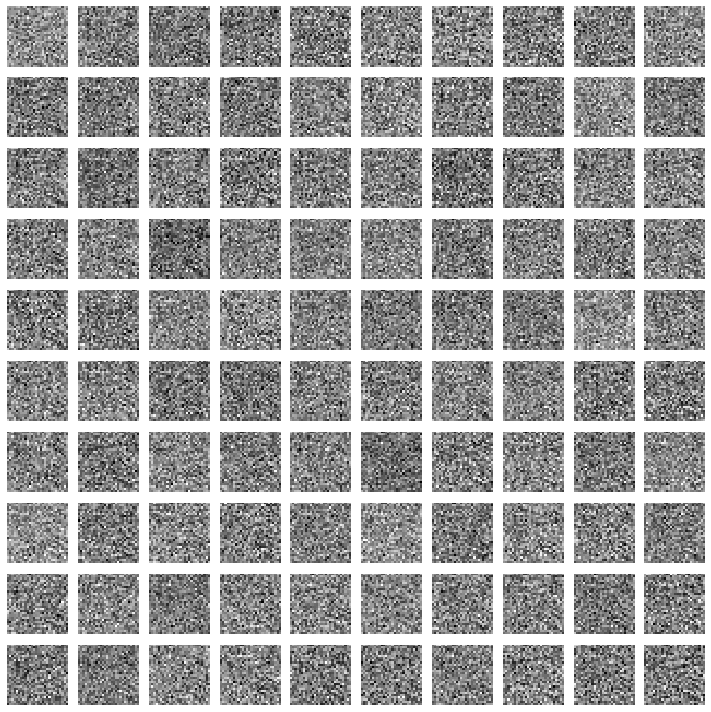

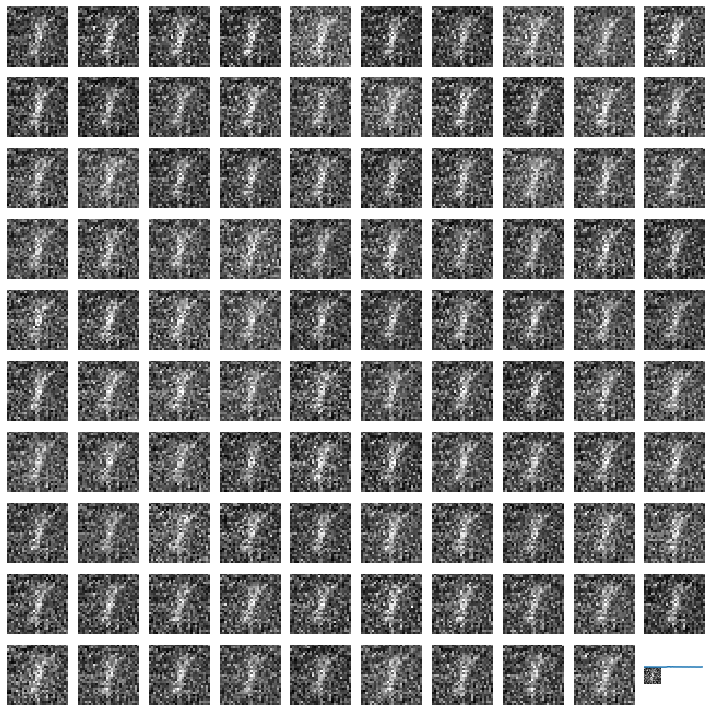

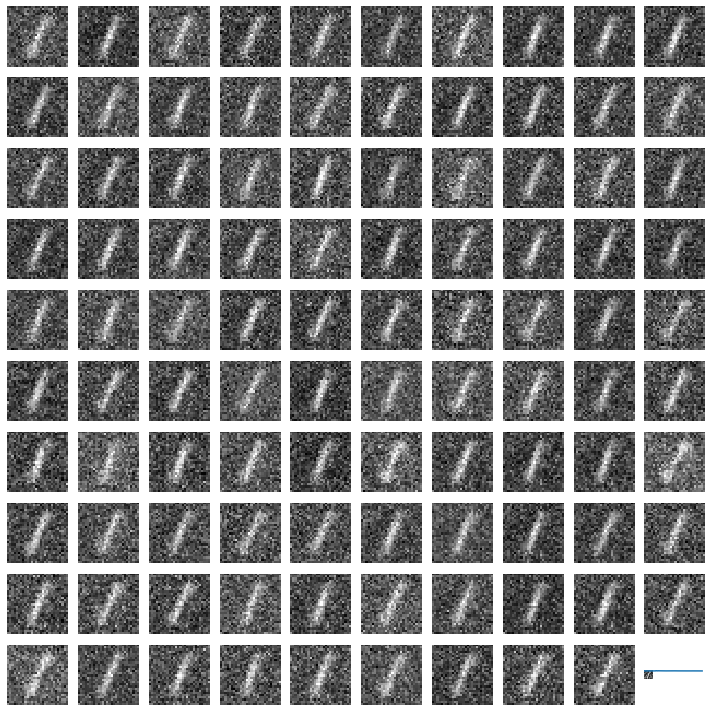

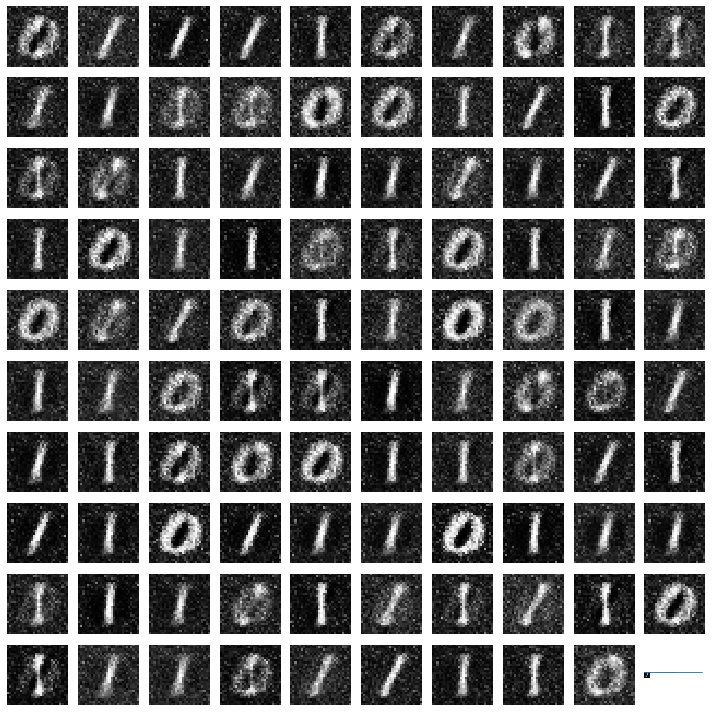

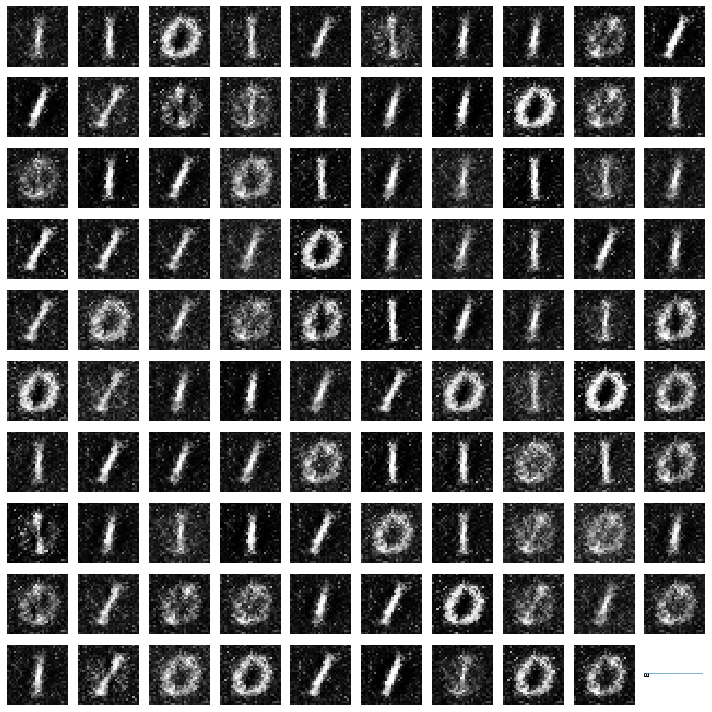

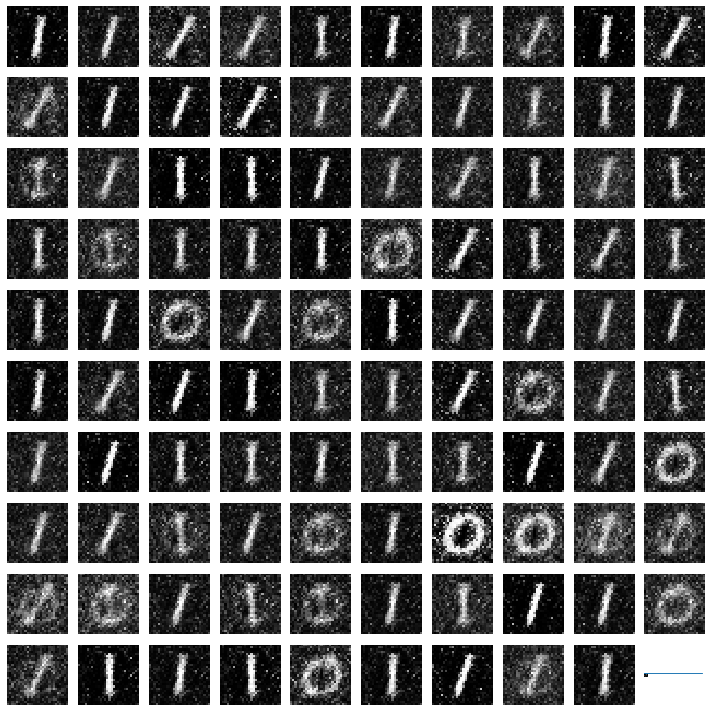

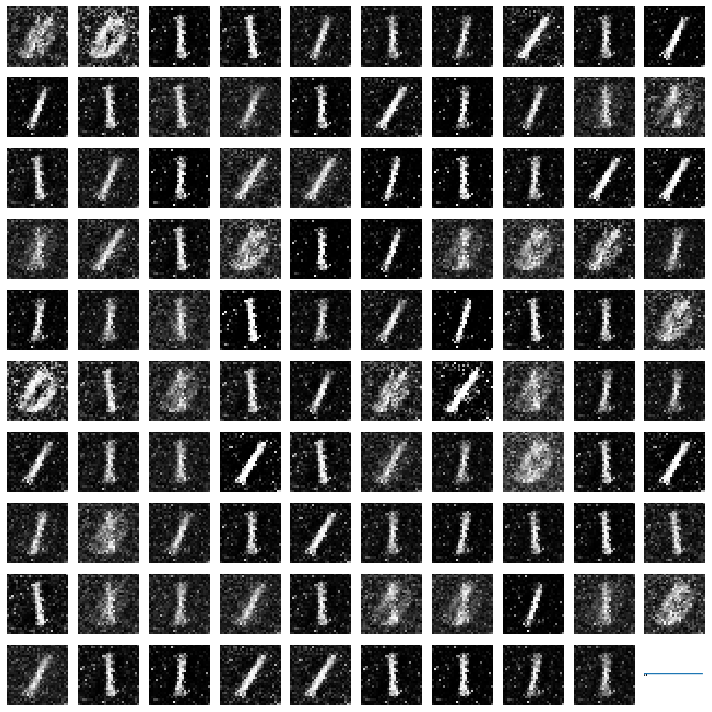

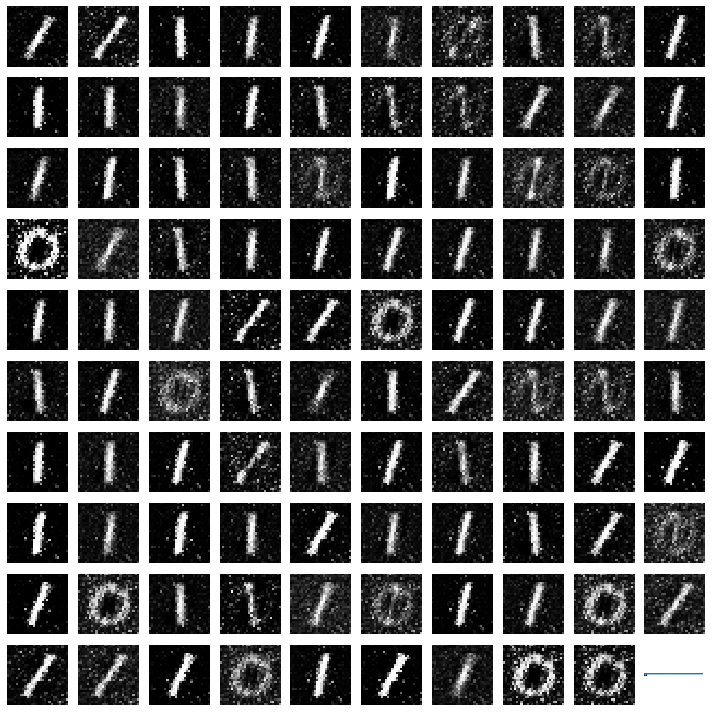

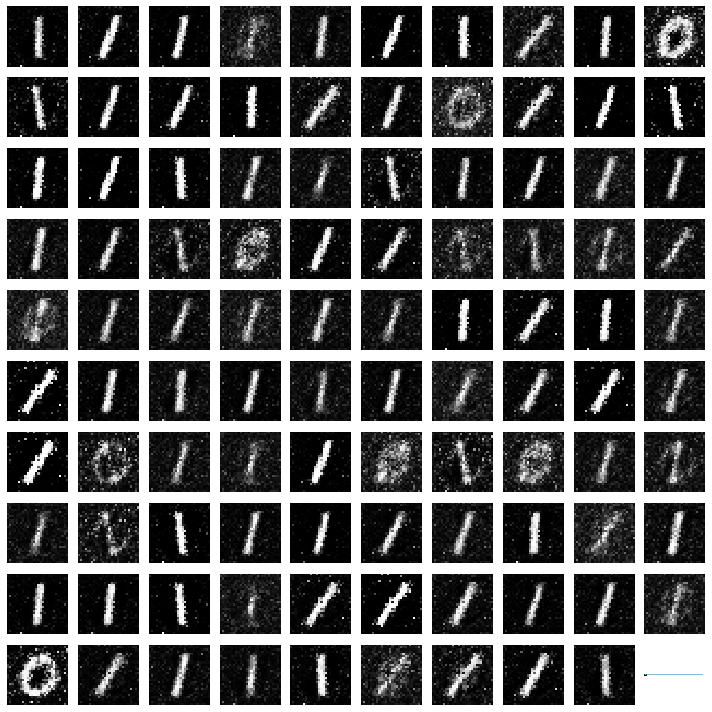

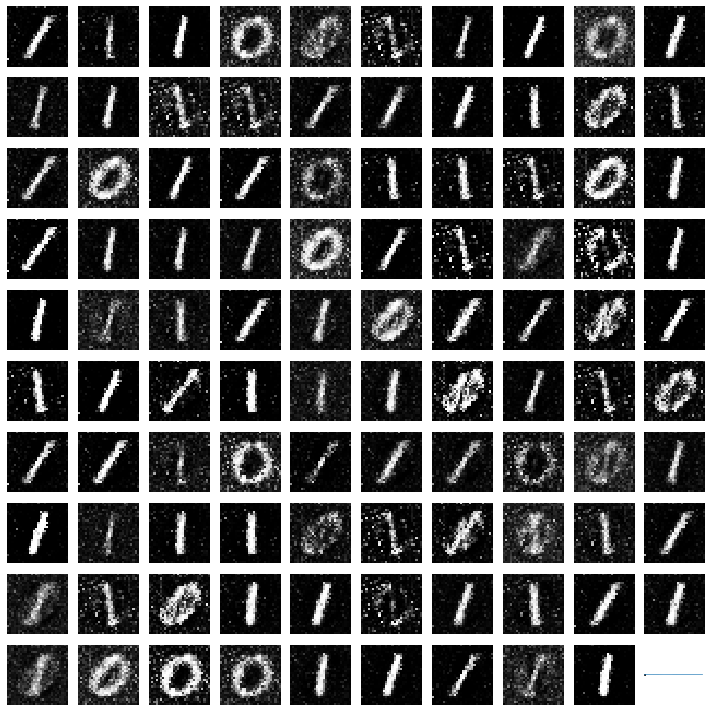

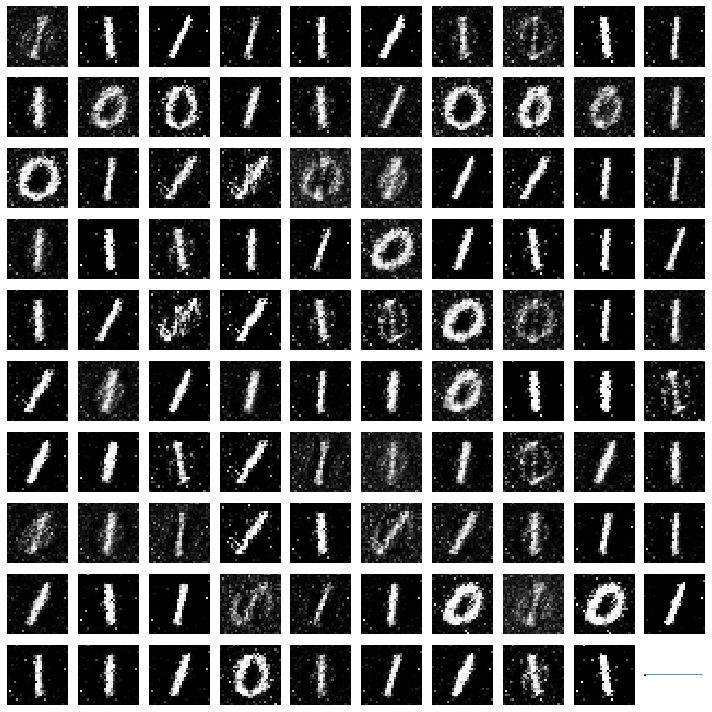

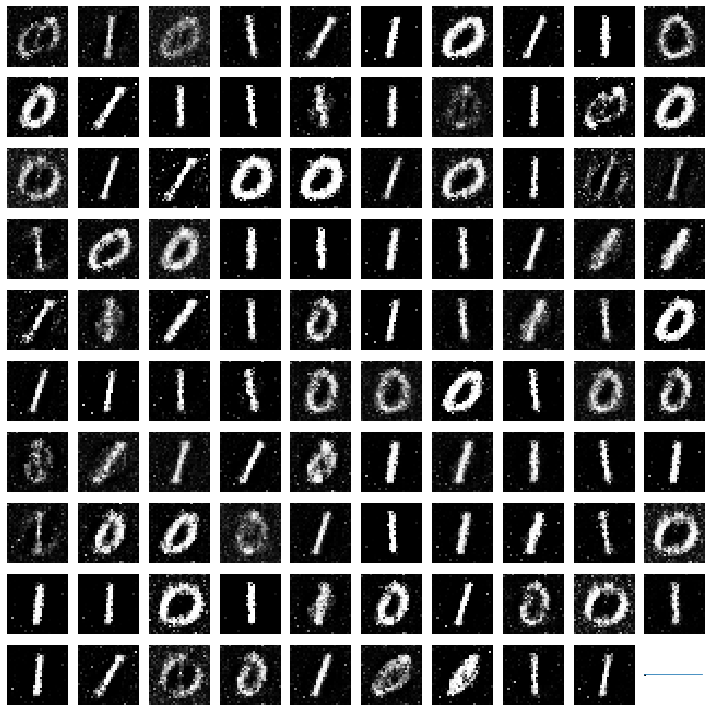

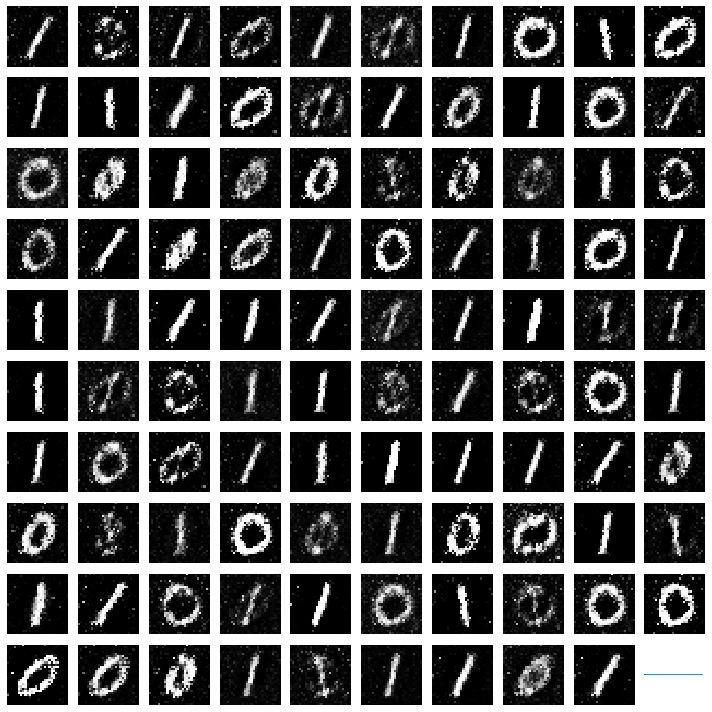

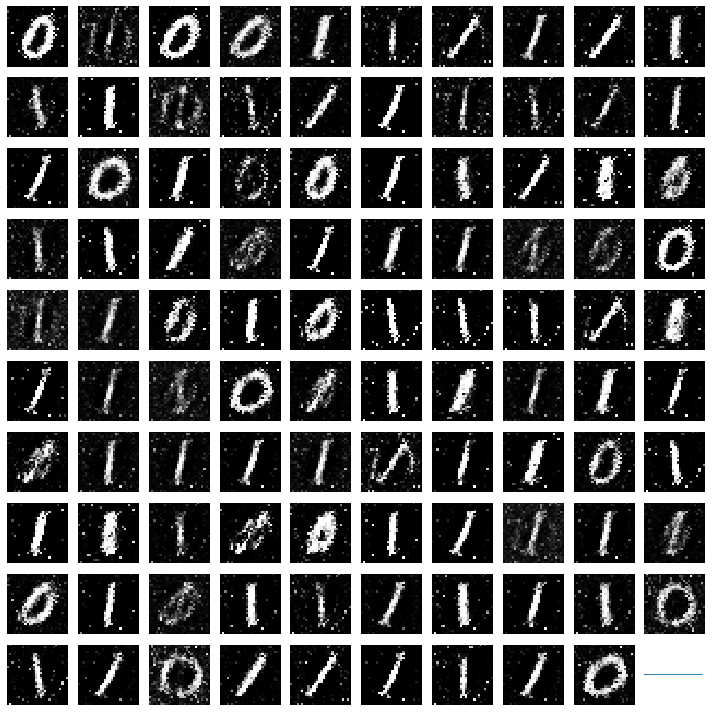

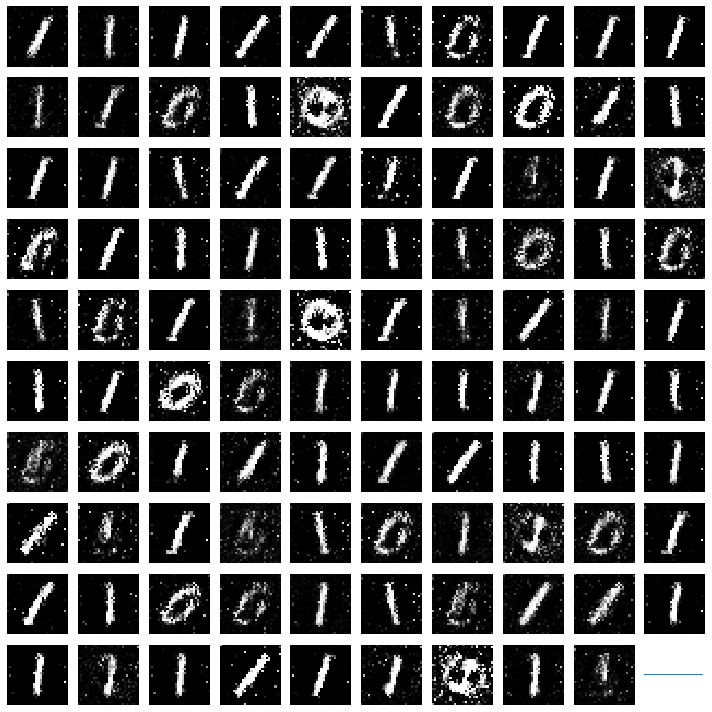

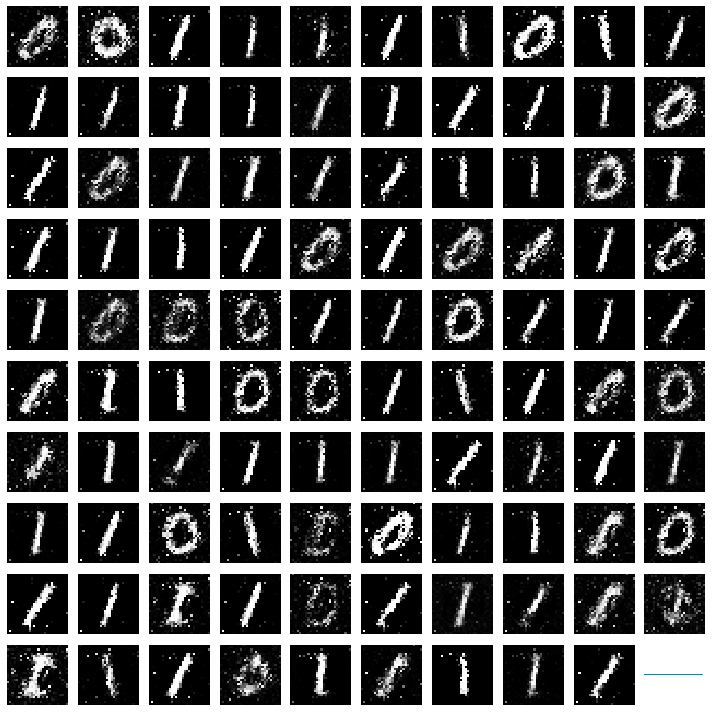

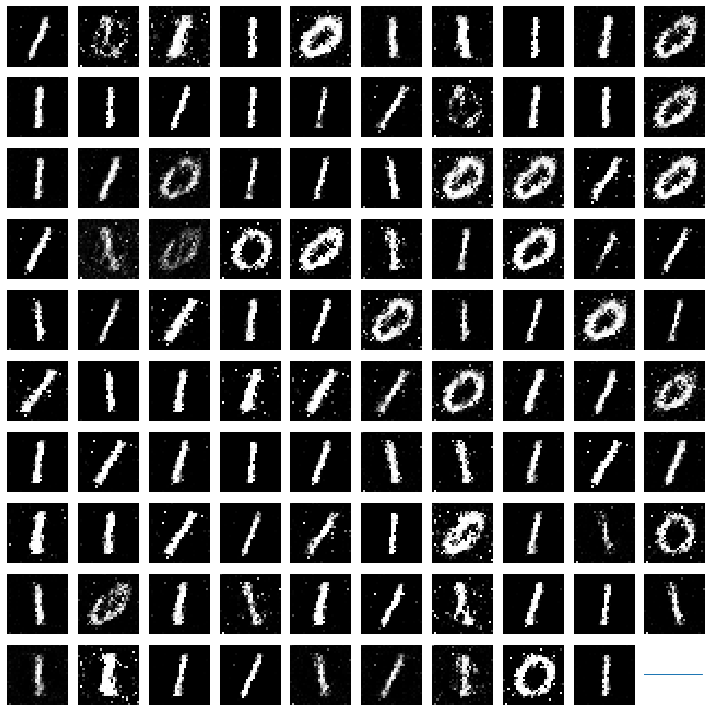

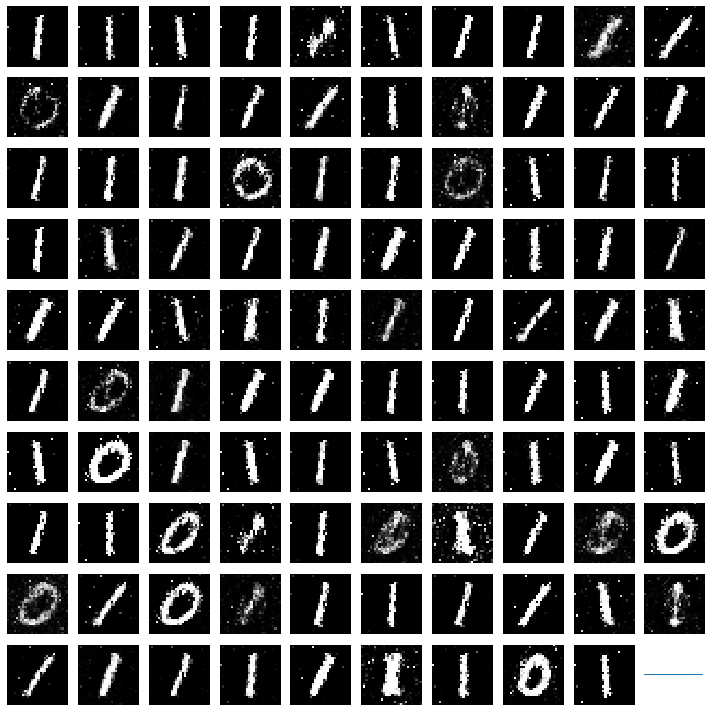

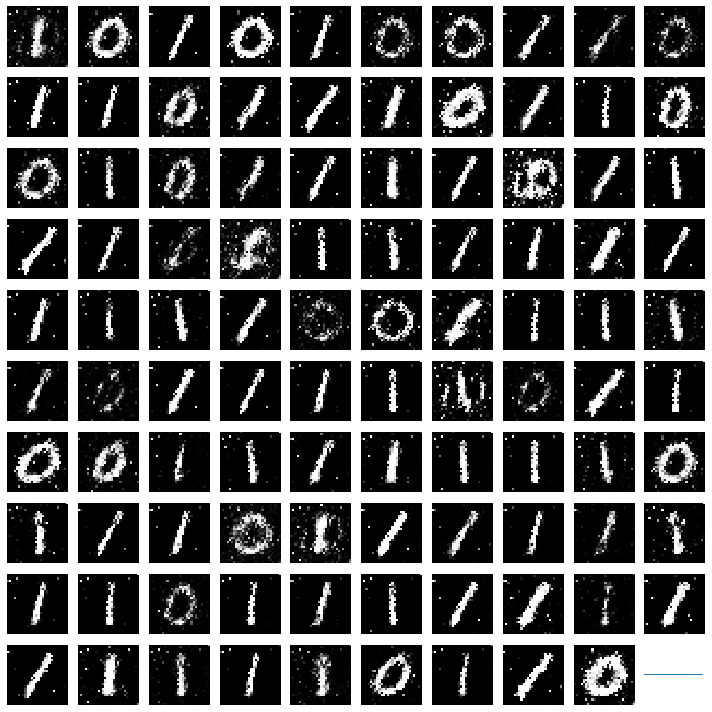

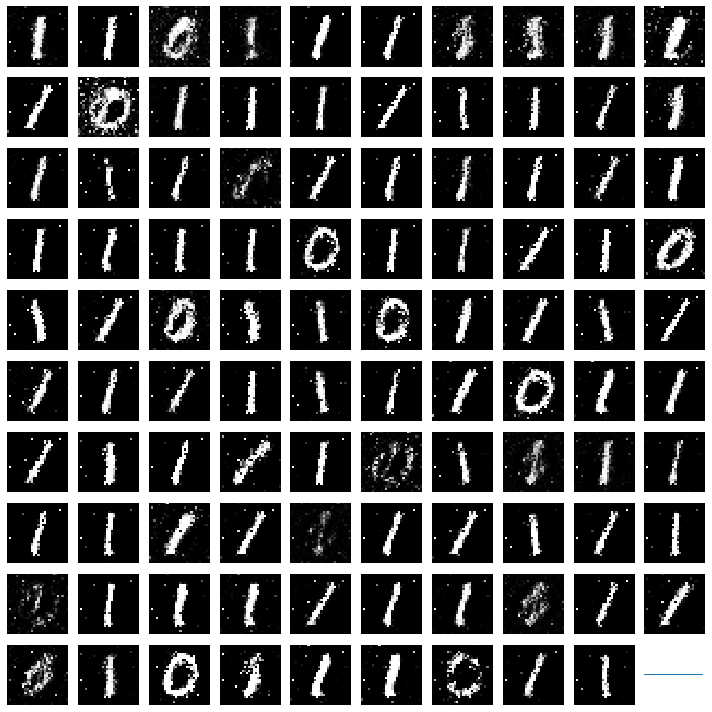

In [7]:
ganPlayerGD = training_gd(create_GAN_player, create_GAN_player)